In [21]:
import os
import struct


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn import linear_model
import tensorboard as tb

In [27]:
dir_path = os.path.join('', 'figs', 'example_plots')
if not os.path.exists(dir_path):
    os.system(f'mkdir -p {dir_path}')

In [28]:

target = 'logs/ffn1'
target = f"{target}/lightning_logs/version_0"

In [57]:
files = os.listdir(f"{target}")
event_file = [i for i in files if i[:7] == 'events.'][0]
contents = None
with open(os.path.join(target, event_file), 'rb') as f:
    contents = f.read()
    
metrics = dict()
    
while(contents):
    header = struct.unpack('Q', contents[:8])

    event_str = contents[12:12+int(header[0])]
    contents = contents[12+int(header[0])+4:]
    
    event = tb.compat.proto.event_pb2.Event()
    event.ParseFromString(event_str)
    if event.HasField('summary'):
            for value in event.summary.value:
                if value.HasField('simple_value'):
                    if value.tag not in metrics:
                        metrics[value.tag] = dict()
                    metrics[value.tag][event.step] = value.simple_value
                    print(value.simple_value, value.tag, event.step)

5905100.5 loss/train 49
0.0 epoch 49
3087033.75 loss/train 99
0.0 epoch 99
208966.109375 loss/val 105
0.0037708361633121967 cosineSim/val 105
0.5010290145874023 mAUROC/val 105
474.8910827636719 peakRank/val 105
0.0 epoch 105
1875390.0 loss/train 149
1.0 epoch 149
1214599.25 loss/train 199
1.0 epoch 199
69024.1015625 loss/val 211
0.015486376360058784 cosineSim/val 211
0.5380243062973022 mAUROC/val 211
383.9312744140625 peakRank/val 211
1.0 epoch 211
795683.625 loss/train 249
2.0 epoch 249
522095.8125 loss/train 299
2.0 epoch 299
35257.328125 loss/val 317
0.023915840312838554 cosineSim/val 317
0.570391833782196 mAUROC/val 317
352.7320861816406 peakRank/val 317
2.0 epoch 317
367814.3125 loss/train 349
3.0 epoch 349
255552.25 loss/train 399
3.0 epoch 399
23649.021484375 loss/val 423
0.0355280265212059 cosineSim/val 423
0.5909163355827332 mAUROC/val 423
347.3656921386719 peakRank/val 423
3.0 epoch 423
199326.90625 loss/train 449
4.0 epoch 449
141415.09375 loss/train 499
4.0 epoch 499
19411.

['loss/train', 'epoch', 'loss/val', 'cosineSim/val', 'mAUROC/val', 'peakRank/val']


Text(0, 0.5, 'Top Peak AUROC')

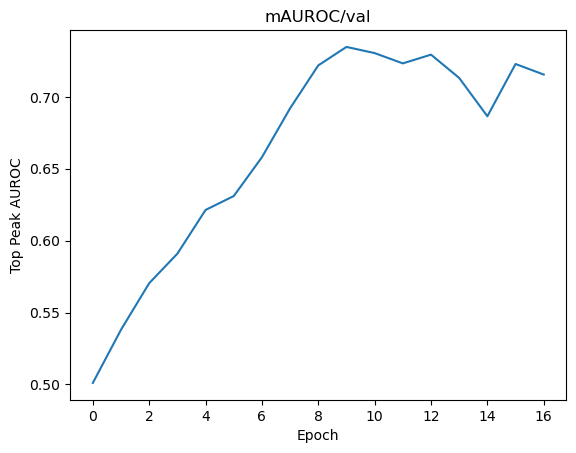

In [66]:
print(list(metrics.keys()))
key = 'mAUROC/val'
m = metrics[key]
plt.plot([m[i] for i in m])
plt.title(key)
plt.xlabel('Epoch')
plt.ylabel('Top Peak AUROC')

# Plot Prediction Histograms

In [179]:
# Toy Predictions

N = 100000
samples_A = np.random.normal(size=(N), scale=0.1, loc=0.4)
samples_B = np.random.normal(size=(N), scale=0.4, loc=0.7)
bins=np.arange(0,1,0.04)

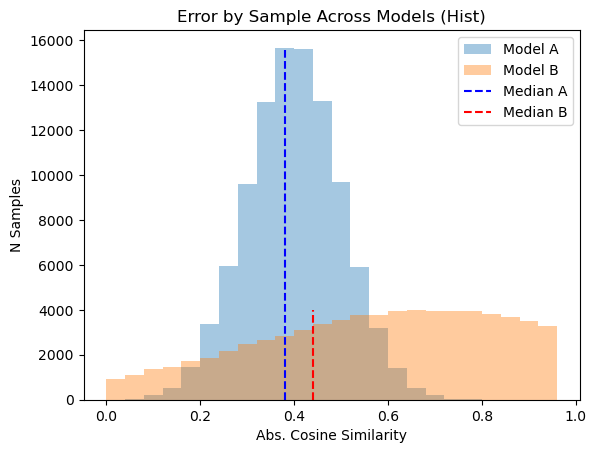

<Figure size 640x480 with 0 Axes>

In [181]:
outA = plt.hist(samples_A, bins=bins, alpha=0.4, label='Model A')
outB = plt.hist(samples_B, bins=bins, alpha=0.4, label='Model B')

cumsumA = np.cumsum(outA[0])/np.sum(outA[0])
under_idx_meanA = np.argmax(cumsumA[cumsumA <= 0.5])
over_idx_meanA = np.argmax(cumsumA[cumsumA >= 0.5])
meanA = np.mean((outA[1][under_idx_meanA], outA[1][over_idx_meanA]))
plt.plot([meanA, meanA],[0,np.max(outA[0])], '--b', label='Median A')

cumsumB = np.cumsum(outB[0])/np.sum(outB[0])
under_idx_meanB = np.argmax(cumsumB[cumsumB <= 0.5])
over_idx_meanB = np.argmax(cumsumB[cumsumB >= 0.5])
meanB = np.mean((outB[1][under_idx_meanB], outB[1][over_idx_meanB]))
plt.plot([meanB, meanB],[0,np.max(outB[0])], '--r', label='Median B')

plt.title('Error by Sample Across Models (Hist)')
plt.xlabel('Abs. Cosine Similarity')
plt.ylabel('N Samples')
plt.legend()

plt.savefig(os.path.join(dir_path, 'error_by_sample.png')) ; plt.show() ; plt.clf()

# Plot Prediction Error vs Variance

We have the predictive posterior:
 $$p(y | x) = \int p(y|\theta)p(\theta|x)d\theta) \approx \frac{1}{N}\sum_i^N p(y | \theta) p(\theta | x)$$
 
In our case, we have vector regression. We will reduce our predicted vector down to a scalar error term.
 $$S_c(\hat{y}, y) = \frac{\sum_i\hat{y}_iy_i}{\sum_i\hat{y}_i^2\sum_iy_i^2} $$
 
Note: In our case, the predictive posterior is a vector - Which we can evaluate element-wise for insight on the predicted mass spectra components. However, evaluating the uncertainty on a vector is a difficult task.
While we can take an error metric on the MAP estimate or the Predictive Posterior, we can also collapse our predicted vector into a scalar error metric and 

In [ ]:
# Toy Errors and Variances

errors = np.linspace(0,1,100)
variances = (errors-1)*2 + 3
variances = variances + np.random.normal(size=variances.shape, scale=0.5, loc=0)
variances = np.maximum(variances, np.zeros(variances.shape)).reshape(-1,1)

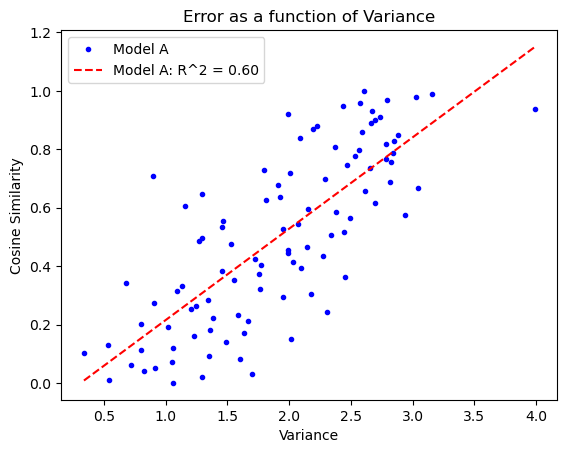

In [177]:
model = linear_model.LinearRegression()
model.fit(variances, errors.reshape(-1,1))
preds = model.predict(variances)

plt.plot(variances, errors, '.b', label=f"Model A")

pretty_x = np.array([np.min(variances), np.max(variances)]).reshape(-1, 1)
pretty_y = model.predict(pretty_x)
plt.plot(pretty_x, pretty_y, '--r', label=f'Model A: R^2 = {r2_score(errors, preds, force_finite=True):.2f}')
plt.legend()

plt.title("Error as a function of Variance")
plt.xlabel("Variance")
plt.ylabel('Cosine Similarity')

plt.savefig(os.path.join(dir_path, 'error_vs_variance.png')) ; plt.show() ; plt.clf()

# Plot: Coverage of Predictive Posterior

Text(0, 0.5, 'Empirical Percentage in Interval')

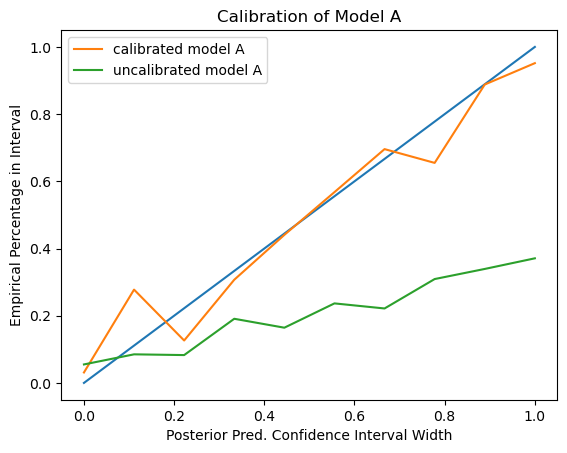

In [92]:
x = np.linspace(0,1,10)

y = x + np.random.normal(size=(x.shape), loc=0.0, scale=0.1)
y = np.maximum(y, 0)


y2 = 0.4*x + np.random.normal(size=(x.shape), loc=0.0, scale=0.05)
y2 = np.maximum(y2, 0)


plt.plot(x, x)
plt.plot(x, y, label='calibrated model A')
plt.plot(x, y2, label='uncalibrated model A')
plt.legend()
plt.title('Calibration of Model A')
plt.xlabel('Posterior Pred. Confidence Interval Width')
plt.ylabel('Empirical Percentage in Interval')

# Plot: Top Peak Probability by Rank

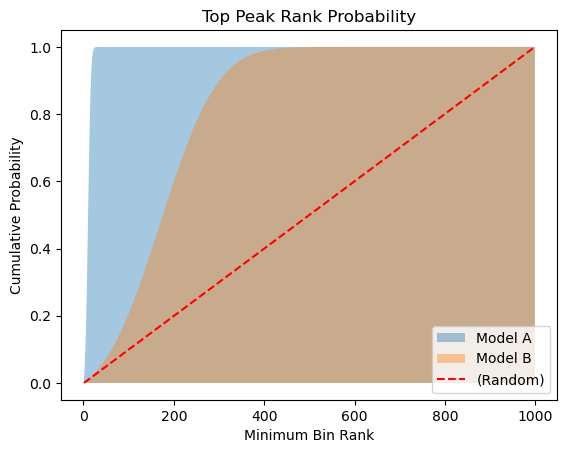

In [77]:
# Toy Predictions

N = 1000000
samples_A = np.random.normal(size=(N), scale=0.005, loc=0.01)
samples_B = np.random.normal(size=(N), scale=0.1, loc=0.17)


bins=np.arange(0,1,0.001)
x = np.arange(1, len(bins))

num_true_bins = 1000
cutoff = 1000

random_baseline = np.linspace(0, 1, len(bins)-1)

outA = np.histogram(samples_A, bins)[0]
#outA = outA/np.sum(outA)
outA = np.cumsum(outA)/np.sum(outA)

outB = np.histogram(samples_B, bins)[0]
#outB = outB/np.sum(outB)
outB = np.cumsum(outB)/np.sum(outB)

plt.fill_between(x, outA, alpha=0.4, label='Model A')
plt.fill_between(x, outB, alpha=0.4, label='Model B')
plt.plot(x[:cutoff], random_baseline[:cutoff], '--r', label='(Random)')
plt.title('Top Peak Rank Probability')
plt.xlabel('Minimum Bin Rank')
plt.ylabel('Cumulative Probability')
plt.legend(loc=4)


24